## Imports

In [ ]:
import pickle
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
import warnings
import logging
warnings.filterwarnings('ignore') # ignores warnings
logging.disable(logging.CRITICAL) # disables logging

from prointvar.pdbx import PDBXreader, PDBXwriter

import subprocess
import shutil
from tempfile import NamedTemporaryFile
from subprocess import CalledProcessError, run, PIPE

## Functions

In [63]:
def save_to_pickle(variable, file_path):
    with open(file_path, 'wb') as file:
        pickle.dump(variable, file)

def read_from_pickle(file_path):
    with open(file_path, 'rb') as file:
        return pickle.load(file)

def find_center_and_dimensions(coords, buffer = 5):
    xs, ys, zs = zip(*coords)
    min_x, max_x = min(xs), max(xs)
    min_y, max_y = min(ys), max(ys)
    min_z, max_z = min(zs), max(zs)
    
    # Calculate center
    center_x = round((max_x + min_x) / 2, 2)
    center_y = round((max_y + min_y) / 2, 2)
    center_z = round((max_z + min_z) / 2, 2)
    
    # Calculate dimensions
    width_x = round(max_x - min_x + buffer, 2) 
    width_y = round(max_y - min_y + buffer, 2) 
    width_z = round(max_z - min_z + buffer, 2) 
    
    return (center_x, center_y, center_z, width_x, width_y, width_z)

def run_povme(command, site_id, retries=3, delay=2):
    for attempt in range(retries):
        try:
            result = run(command, check=True, stdout=PIPE, stderr=PIPE)
            return result
        except CalledProcessError as e:
            print(f"Attempt {attempt+1} failed for {site_id}")
            time.sleep(delay)  # wait before retrying
    raise Exception("All attempts to run POVME failed.")

def extract_values_from_file(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()  # Read all lines from the file

    # Assert that there is exactly one line in the file
    assert len(lines) == 1, "File must contain exactly one line"

    # Split the line into parts and convert them to the appropriate types
    line = lines[0].strip()  # Remove any trailing whitespace
    parts = line.split()     # Split the line into parts by whitespace

    # Convert the first part to integer and the second part to float
    first_value = int(parts[0])
    second_value = float(parts[1])

    return first_value, second_value

## Input data

In [4]:
clean_rep_chains_dir = './../../clean_rep_chains'

In [5]:
pockets_df = pd.read_pickle("./results/PDB_sites_sifted_V2.pkl").sort_values(["rep_chain", "ID"]).reset_index(drop = True)

In [6]:
pockets_df_reps = pockets_df.rep_chain.unique().tolist()

In [7]:
len(pockets_df_reps)

3448

In [8]:
bad_reps = read_from_pickle("./results/other_errrors_reps.pkl")

In [9]:
pockets_df_reps_filt = [el for el in pockets_df_reps if el not in bad_reps]

In [10]:
len(pockets_df_reps_filt)

3416

## Running POVME on all LIGYSIS defined sites

In [36]:
site_average_dists = {}

In [50]:
# Path variables
template_ini_path = '/Users/2394007/Documents/PHD/LOCAL/JSU_P2RANK/POVME-2.2.2/POVME_JSU.ini'
povme_path = '/Users/2394007/Documents/PHD/LOCAL/JSU_P2RANK/POVME-2.2.2/POVME2.py'
povme_output_dir = '/Users/2394007/Documents/PHD/LOCAL/JSU_P2RANK/POVME-2.2.2/out/ligysis'

# Read the template INI file once
with open(template_ini_path, 'r') as file:
    ini_content = file.readlines()

errors = []
for i, rep_chain in enumerate(pockets_df_reps_filt):
    if i % 100 == 0:
        print(i)
    pdb_path = os.path.join(clean_rep_chains_dir, f'{rep_chain}.clean.pdb')
    
    try:
        df = PDBXreader(inputfile=pdb_path).atoms(format_type="pdb", excluded=()).reset_index(drop=True)

    except Exception as e:
        print(f"Error reading PDB: {e}")
        errors.append(rep_chain)
        continue

    rep_chain_sites_df = pockets_df.query('rep_chain == @rep_chain')
    
    for _, row in rep_chain_sites_df.iterrows():
        site_ress = [str(el) for el in row.aas if el]
        if not site_ress:
            continue
        
        site_atoms = df.query('label_seq_id_full in @site_ress')
        site_coords = np.array(list(zip(site_atoms.Cartn_x, site_atoms.Cartn_y, site_atoms.Cartn_z)))
        CA_atoms = site_atoms.query('label_atom_id == "CA"')
        CA_dists = pdist(CA_atoms[["Cartn_x", "Cartn_y", "Cartn_z"]].values, metric='euclidean')
        average_distance = round(np.mean(CA_dists), 2)
        site_average_dists[rep_chain+"_"+str(row.ID)] = average_distance
        if average_distance > 25:
            print(f'Skipping Pocket {row.ID} of {rep_chain} as its average CA-atom distance is {average_distance}')
            errors.append(site_id)
            continue
        #print(average_distance)
        #continue
        
        
        center_dims = find_center_and_dimensions(site_coords, buffer=0)
        center = ' '.join(map(str, center_dims[:3]))
        dims_str = " ".join([str(el) for el in center_dims])
        output_file_name = os.path.join(povme_output_dir, f"{rep_chain}_{row.ID}", f"{rep_chain}_{row.ID}_")
        main_output_file_path = os.path.join(output_file_name + "volumes.tabbed.txt")
        
        if os.path.isfile(main_output_file_path):
            # print(f'{i}: Output exists for {rep_chain}_{row.ID}')
            continue

        try:
            with NamedTemporaryFile(delete=False, mode='w', suffix='.ini', dir='./', prefix='POVME_ligysis_') as temp_ini:
                for line in ini_content:
                    if "PointsInclusionBox" in line:
                        line = f"PointsInclusionBox {dims_str} #CHANGE FOR EACH INPUT\n"
                    elif "PDBFileName " in line:
                        line = f"PDBFileName {pdb_path}\n"
                    elif "ContiguousPocketSeedSphere " in line:
                        line = f"ContiguousPocketSeedSphere {center} 5.0\n"
                    elif "OutputFilenamePrefix" in line:
                        line = f"OutputFilenamePrefix {output_file_name}\n"
                    temp_ini.write(line)

            command = ['python', povme_path, temp_ini.name]
            site_id = f"{rep_chain}_{row.ID}"
            run_povme(command, site_id, retries=5, delay=1)
            print(f"{i}: POVME completed for {rep_chain} SITE: {row.ID}")

        except CalledProcessError as e:
            print(f"{i}: POVME execution failed for {rep_chain} SITE: {row.ID}: {e}")
            print(' '.join(command))
            errors.append(site_id)
        except Exception as e:
            print(f"{i}: An error occurred processing {rep_chain} SITE: {row.ID}: {e}")
            errors.append(site_id)
        finally:
            if os.path.exists(temp_ini.name):
                os.unlink(temp_ini.name)



0
100
200
300
400
Skipping Pocket 0 of 2b48_A as its average CA-atom distance is 25.13
Skipping Pocket 1 of 2ch9_A as its average CA-atom distance is 35.04
500
600
Skipping Pocket 2 of 2ffu_A as its average CA-atom distance is 32.28
700
800
900
1000
Skipping Pocket 0 of 2ydx_D as its average CA-atom distance is 28.82
1100
Skipping Pocket 0 of 3ff6_D as its average CA-atom distance is 25.19
1200
Skipping Pocket 0 of 3j0a_A as its average CA-atom distance is 30.36
Skipping Pocket 0 of 3k2s_B as its average CA-atom distance is 28.95
Skipping Pocket 1 of 3k2s_B as its average CA-atom distance is 68.07
Skipping Pocket 4 of 3k2s_B as its average CA-atom distance is 31.64
Skipping Pocket 7 of 3k2s_B as its average CA-atom distance is 58.61
Skipping Pocket 9 of 3k2s_B as its average CA-atom distance is 29.28
Skipping Pocket 12 of 3k2s_B as its average CA-atom distance is 39.24
Skipping Pocket 13 of 3k2s_B as its average CA-atom distance is 51.81
Skipping Pocket 14 of 3k2s_B as its average CA-a

In [51]:
len(site_average_dists)

8168

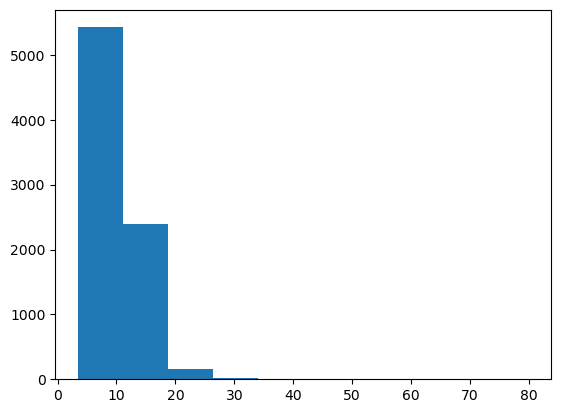

In [58]:
plt.hist(site_average_dists.values())
plt.show()

In [59]:
print(len(errors)) #429 --> 51 --> mostly massive sites probably incorrect (due to conformational changes in PDB structures)

50


In [60]:
pocket_dirs = sorted(os.listdir(povme_output_dir))[1:]

In [64]:
vols_dict = {}
errors = []
for i, pocket_dir in enumerate(pocket_dirs):
    #if i % 1000 == 0:
    #    print(i)
    pocket_dir_path = os.path.join(povme_output_dir, pocket_dir)
    pocket_d = pocket_dir.split("_")
    rep_chain = "_".join(pocket_d[:2])
    vol_file = os.path.join(pocket_dir_path, f'{pocket_dir}_volumes.tabbed.txt')
    try:
        _, vol = extract_values_from_file(vol_file)
        vols_dict[(rep_chain, int(pocket_d[2]))] = int(vol)
    except:
        #raise
        #print(f'No pocket volume for {pocket_dir}')
        errors.append(pocket_dir)
    #break

In [65]:
print(len(errors))

6


In [66]:
print(len(vols_dict))

8238


In [67]:
print(len(pockets_df))

8244


In [68]:
pockets_df["volume"] = pockets_df.set_index(["rep_chain", "ID"]).index.map(vols_dict)

In [69]:
pockets_df.query('volume != volume & n_aas != 0 & rep_chain not in @bad_reps') # ALL VN-EGNN POCKETS HAVE CALCULATED VOLUME

,ACC,SEG,ID,up_aas,n_aas,SEG_ID,SITE_NAME,pdb_id,auth_asym_id,struct_asym_id,rep_chain,RoG,aas,centre,volume
2603,P02647,1,14,"[118, 121, 122, 125, 190, 194]",6,P02647_1,P02647_1_14,3k2s,B,B,3k2s_B,43.06,"[94, 97, 98, 101, 166, 170]","(42.59, 105.452, 60.175)",NaN
2616,P02647,1,27,"[66, 226, 227, 230, 231, 234, 235, 237, 238, 242]",10,P02647_1,P02647_1_27,3k2s,B,B,3k2s_B,45.16,"[42, 202, 203, 206, 207, 210, 211, 213, 214, 218]","(57.21, 40.613, 74.367)",NaN


In [70]:
save_to_pickle(vols_dict, "./results/LIGYSIS_volumes_dict.pkl")